# MODELING DATA (use cars_data)

## IMPORTING

In [130]:
%reset -f
import numpy as np
import pandas as pd
import math

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

## SET DEFAULT OUTPUT DISPLAY

In [131]:
# Set pandas output display to have one digit for decimal places and limit it to printing 15 rows.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

## SET FEATURES NAME AND READ CSV FILE

In [132]:
# Provide the names for the columns since the CSV file with the data does not have a header row.
feature_names = ['symboling', 'normalized-losses', 'make', 'fuel-type',
        'aspiration', 'num-doors', 'body-style', 'drive-wheels',
        'engine-location', 'wheel-base', 'length', 'width', 'height', 'weight',
        'engine-type', 'num-cylinders', 'engine-size', 'fuel-system', 'bore',
        'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
        'highway-mpg', 'price']


# Load in the data from a CSV file that is comma separated.
car_data = pd.read_csv('https://storage.googleapis.com/mledu-datasets/cars_data.csv',
                        sep=',', names=feature_names, header=None, encoding='latin-1')


# We'll then randomize the data, just to be sure not to get any pathological
# ordering effects that might harm the performance of Stochastic Gradient Descent.
car_data = car_data.reindex(np.random.permutation(car_data.index))

print("Data set loaded. Num examples: ", len(car_data))

Data set loaded. Num examples:  205


## DETERMINE CATEGORICAL OR NUMERIC FEATURES

In [133]:
LABEL = 'price'

numeric_feature_names = ['symboling', 'normalized-losses', 'wheel-base',
        'length', 'width', 'height', 'weight', 'engine-size', 'horsepower',
        'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke',
         'compression-ratio'] #do not include LABEL (price)                         (below)

categorical_feature_names = list(set(feature_names) - set(numeric_feature_names) - set([LABEL]))

#check if raise error
assert len(numeric_feature_names) == 15
assert len(categorical_feature_names) == 10

## COERCE NUMERIC FEATURES TO NUMBER AND FILL MISSING VALUES

In [134]:
# Coerce the numeric features to numbers. This is necessary because the model crashes. Not all the values are numeric.
for feature_name in numeric_feature_names + [LABEL]:
    # If ‘coerce’, then invalid parsing will be set as NaN.
    car_data[feature_name] = pd.to_numeric(car_data[feature_name], errors='coerce')

# Fill missing values (NaN) with 0.00.
# Is this an OK thing to do? You may want to come back and revisit this decision later.
car_data.fillna(0, inplace=True)

In [135]:
car_data[feature_names]

,symboling,normalized-losses,make,fuel-type,aspiration,num-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
48,0,0.00,jaguar,gas,std,four,sedan,rwd,front,113.00,...,258,mpfi,3.63,4.17,8.10,176.00,4750.00,15,19,35550.00
6,1,158.00,audi,gas,std,four,sedan,fwd,front,105.80,...,136,mpfi,3.19,3.40,8.50,110.00,5500.00,19,25,17710.00
77,2,161.00,mitsubishi,gas,std,two,hatchback,fwd,front,93.70,...,92,2bbl,2.97,3.23,9.40,68.00,5500.00,31,38,6189.00
199,-1,74.00,volvo,gas,turbo,four,wagon,rwd,front,104.30,...,130,mpfi,3.62,3.15,7.50,162.00,5100.00,17,22,18950.00
55,3,150.00,mazda,gas,std,two,hatchback,rwd,front,95.30,...,70,4bbl,0.00,0.00,9.40,101.00,6000.00,17,23,10945.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,0,0.00,peugot,gas,std,four,wagon,rwd,front,114.20,...,120,mpfi,3.46,2.19,8.40,95.00,5000.00,19,24,16695.00
124,3,0.00,plymouth,gas,turbo,two,hatchback,rwd,front,95.90,...,156,spdi,3.59,3.86,7.00,145.00,5000.00,19,24,12764.00
18,2,121.00,chevrolet,gas,std,two,hatchback,fwd,front,88.40,...,61,2bbl,2.91,3.03,9.50,48.00,5100.00,47,53,5151.00
127,3,0.00,porsche,gas,std,two,hardtop,rwd,rear,89.50,...,194,mpfi,3.74,2.90,9.50,207.00,5900.00,17,25,34028.00


## TRAINING MODEL BY NOMALIZING (Z-SCORE), TRANSFORMING (VOCABULARY)

In [136]:
# Z-score normalization subtracts the mean and divides by the standard deviation,
# to give a roughly standard normal distribution (mean = 0, std = 1) under a
# normal distribution assumption. Epsilon prevents divide by zero.
batch_size = 16

x_df = car_data[numeric_feature_names + categorical_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

epsilon = 0.000001
model_feature_columns = [
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, vocabulary_list=car_data[feature_name].unique()))
    for feature_name in categorical_feature_names
] + [
    tf.feature_column.numeric_column(feature_name,
                                     normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
    for feature_name in numeric_feature_names
]


print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
    est.train(train_input_fn, steps=num_training_steps // num_print_statements)
    scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the 
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
    print('scores', scores)

model_feature_columns [IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='fuel-system', vocabulary_list=('mpfi', '2bbl', '4bbl', '1bbl', 'idi', 'spdi', 'mfi', 'spfi'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='make', vocabulary_list=('jaguar', 'audi', 'mitsubishi', 'volvo', 'mazda', 'nissan', 'toyota', 'honda', 'porsche', 'peugot', 'mercury', 'subaru', 'volkswagen', 'saab', 'mercedes-benz', 'dodge', 'bmw', 'isuzu', 'plymouth', 'chevrolet', 'alfa-romero', 'renault'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='fuel-type', vocabulary_list=('gas', 'diesel'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='engine-type', vocabulary_list=('dohc', 'ohc', 'rotor', 'ohcf', 'l', 'ohcv', 'dohcv'), dtype=tf.string, default_value=-1

/var/folders/4v/34qqk3qs1d7ctyx_lnbwcg680000gn/T/ipykernel_66302/4067196635.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/4v/34qqk3qs1d7ctyx_lnbwcg680000gn/T/tmp9h5dz2y5/model.ckpt.
INFO:tensorflow:/var/folders/4v/34qqk3qs1d7ctyx_lnbwcg680000gn/T/tmp9h5dz2y5/model.ckpt-0.data-00000-of-00001
INFO:tensorflow:0
INFO:tensorflow:/var/folders/4v/34qqk3qs1d7ctyx_lnbwcg680000gn/T/tmp9h5dz2y5/model.ckpt-0.index
INFO:tensorflow:0
INFO:tensorflow:/var/folders/4v/34qqk3qs1d7ctyx_lnbwcg680000gn/T/tmp9h5dz2y5/model.ckpt-0.meta
INFO:tensorflow:200
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 4017986000.0, step = 1
INFO:tensorflow:global_step/sec: 230.598
INFO:tensorflow:loss = 2139786200.0, step = 101 (0.448 sec)
INFO:tensorflow:global_st

INFO:tensorflow:Calling model_fn.


/var/folders/4v/34qqk3qs1d7ctyx_lnbwcg680000gn/T/ipykernel_66302/4067196635.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/4v/34qqk3qs1d7ctyx_lnbwcg680000gn/T/tmp9h5dz2y5/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


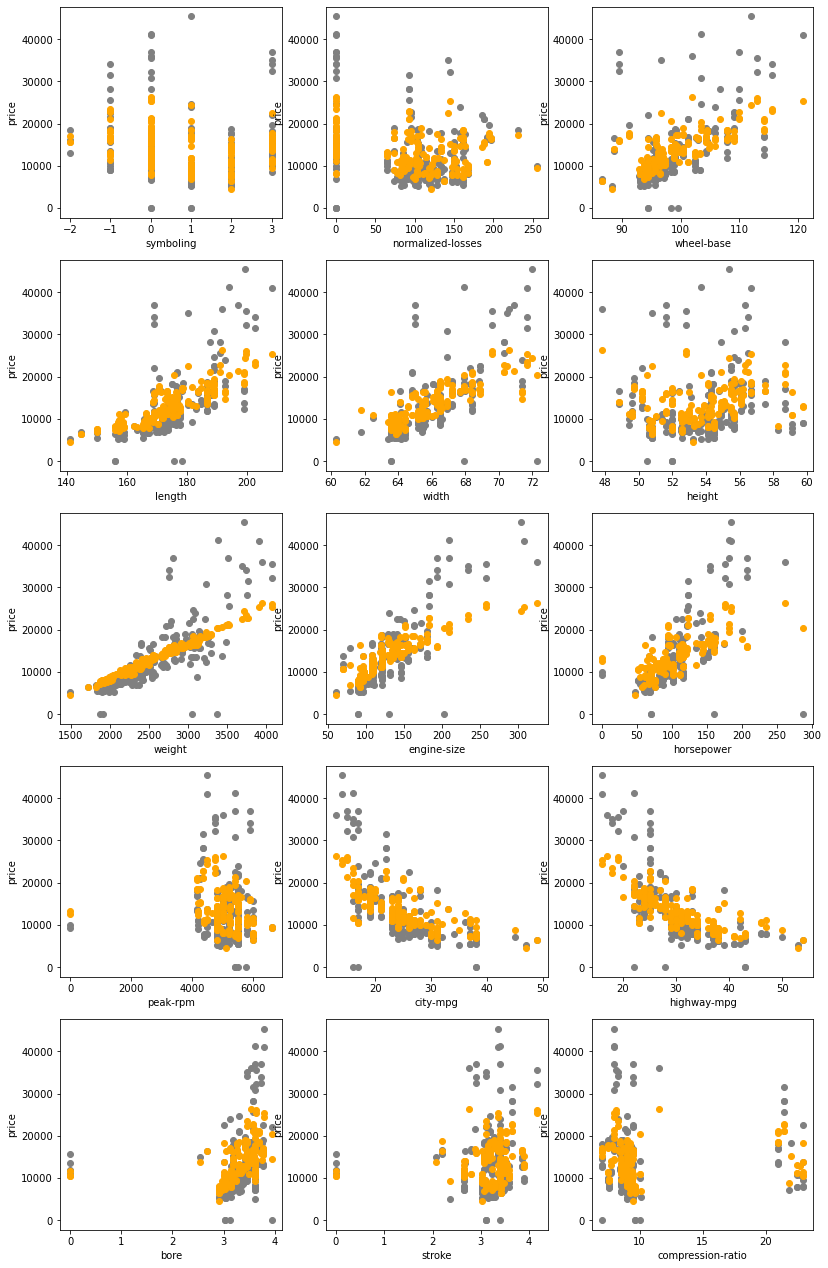

In [137]:
from matplotlib import pyplot as plt

def scatter_plot_inference_grid(est, x_df, feature_names):
    """Plots the predictions of the model against each feature.
  
    Args:
    est: The trained tf.Estimator.
    x_df: The pandas dataframe with the input data (used to create
        predict_input_fn).
    feature_names: An iterable of string feature names to plot.
    """
    def scatter_plot_inference(axis, x_axis_feature_name, y_axis_feature_name, predictions):
    #"""Generate one subplot."""
    # Plot the real data in grey.
        y_axis_feature_name = 'price'
        axis.set_ylabel(y_axis_feature_name)
        axis.set_xlabel(x_axis_feature_name)
        axis.scatter(car_data[x_axis_feature_name], car_data[y_axis_feature_name], c='grey')

    # Plot the predicted data in orange.
        axis.scatter(car_data[x_axis_feature_name], predictions, c='orange')

    predict_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=x_df,
        batch_size=batch_size,
        shuffle=False)

    predictions = [x['predictions'][0] for x in est.predict(predict_input_fn)]
  
    num_cols = 3
    num_rows = int(math.ceil(len(feature_names)/float(num_cols)))
    f, axarr = plt.subplots(num_rows, num_cols)
    size = 4.5
    f.set_size_inches(num_cols*size, num_rows*size)
  
    for i, feature_name in enumerate(numeric_feature_names):
        axis = axarr[int(i/num_cols), i%num_cols]
        scatter_plot_inference(axis, feature_name, 'price', predictions)
    plt.show()

scatter_plot_inference_grid(est, x_df, numeric_feature_names)

In [138]:
for feature_name in categorical_feature_names:
    print(car_data[feature_name].unique())

['mpfi' '2bbl' '4bbl' '1bbl' 'idi' 'spdi' 'mfi' 'spfi']
['jaguar' 'audi' 'mitsubishi' 'volvo' 'mazda' 'nissan' 'toyota' 'honda'
 'porsche' 'peugot' 'mercury' 'subaru' 'volkswagen' 'saab' 'mercedes-benz'
 'dodge' 'bmw' 'isuzu' 'plymouth' 'chevrolet' 'alfa-romero' 'renault']
['gas' 'diesel']
['dohc' 'ohc' 'rotor' 'ohcf' 'l' 'ohcv' 'dohcv']
['std' 'turbo']
['sedan' 'hatchback' 'wagon' 'convertible' 'hardtop']
['six' 'five' 'four' 'two' 'eight' 'twelve' 'three']
['rwd' 'fwd' '4wd']
['front' 'rear']
['four' 'two' '?']
